# Solving a SAT sample

## 3-SAT in Disjunctive Normal Form (DNF)

Base on the following description:\
https://docs.dwavesys.com/docs/latest/c_gs_5.html

**Sample:**

$ (x_1  \land \lnot x_2 \land \lnot x_3) \lor (\lnot x_1 \land x_2 \land \lnot x_3) \lor (\lnot x_1 \land \lnot x_2 \land x_3) $

In [1]:
import itertools

def sat(x1,x2,x3):
    return (x1 and not x2 and not x3) or (not x1 and x2 and not x3) or (not x1 and not x2 and x3)
i = 1
for (x1,x2,x3) in list(itertools.product([False,True],[False,True],[False,True])):
    print("State %d:" % i,":", x1,x2,x3,'-->',sat(x1,x2,x3))
    i += 1

State 1: : False False False --> False
State 2: : False False True --> True
State 3: : False True False --> True
State 4: : False True True --> False
State 5: : True False False --> True
State 6: : True False True --> False
State 7: : True True False --> False
State 8: : True True True --> False


## Formulating Problem as Constraint
### Constraint Satisfaction Problem (CSP)
$x_1 + x_2 + x_3 = 1 $

## Formulating as QUBO as Squared Constraint with Three Binary Variables


$ \min{E(q_1,q_2,q_3) = (q_1 + q_2 + q_3 - 1)^2}$ 

$E$ is the energy that has to be minimized on the QPU.

$ E(q_1,q_2,q_3) = q_1^2 + q_2^2 + q_3^2 + 2q_1q_2 + 2q_1q_3 + 2q_2q_3 - 2q_1 - 2q_2 - 2q_3 + 1$

with $q_i^2 = q_i$

$ E(q_1,q_2,q_3) = 2q_1q_2 + 2q_1q_3 + 2q_2q_3 - q_1 - q_2 - q_3 + 1$


In [2]:
def E(x1,x2,x3):
    return 2*x1*x2 + 2*x1*x3 + 2*x2*x3 - x1 - x2 -x3 + 1
i = 1
for (x1,x2,x3) in list(itertools.product([False,True],[False,True],[False,True])):
    print("energy %d:" % i,":", x1,x2,x3,'-->',E(x1,x2,x3))
    i += 1

energy 1: : False False False --> 1
energy 2: : False False True --> 0
energy 3: : False True False --> 0
energy 4: : False True True --> 1
energy 5: : True False False --> 0
energy 6: : True False True --> 1
energy 7: : True True False --> 1
energy 8: : True True True --> 4


## Problem as Graph

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


def draw_graph(G,colors,pos):
    default_axes = plt.axes(frameon=False)
    edge_labels = nx.get_edge_attributes(G, "weight")
    node_labels = nx.get_node_attributes(G, "weight")
    nx.draw_networkx(G, node_size=300, alpha=0.8, ax=default_axes,node_color=colors, pos=Gpos,labels=node_labels,font_size=8)
    
#    # node labels
#    nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif",labels=node_labels)    
#    print(edge_labels)
    
    nx.draw_networkx_edge_labels(G,pos, edge_labels=edge_labels)


In [4]:
n = 3
#edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]  # (node_i, node_j, weight)
edges = [(0,1,2),(0,2,2),(1,2,2)]

In [5]:
G = nx.Graph()
#G.add_nodes_from(np.arange(0, n, 1))
G.add_node(0,weight=-1)
G.add_node(1,weight=-1)
G.add_node(2,weight=-1)
G.add_weighted_edges_from(edges)

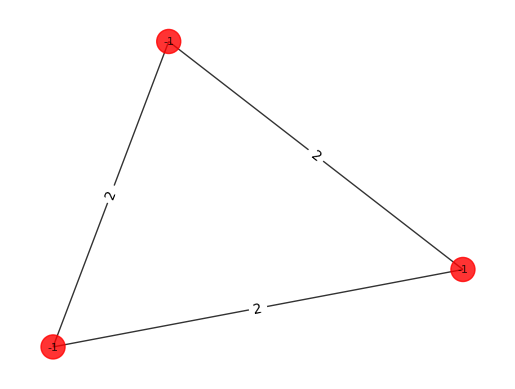

In [6]:
colors = ["r" for node in G.nodes()]
Gpos = nx.spring_layout(G)

draw_graph(G,colors,Gpos)

Here, the energy function is transformed to \
$ E(q_1,q_2,q_3) = 2q_1q_2 + 2q_1q_3 + 2q_2q_3 - q_1 - q_2 - q_3$

This is an Energy shift $ E \rightarrow E - 1$. But constants have no influence on a minimizing problem.

In [7]:
dict(G.nodes(data='weight', default=1))

{0: -1, 1: -1, 2: -1}

In [8]:
nx.get_node_attributes(G, "weight")

{0: -1, 1: -1, 2: -1}

In [9]:
nx.get_edge_attributes(G, "weight")

{(0, 1): 2, (0, 2): 2, (1, 2): 2}

## QUBO Matrix

In [10]:
import dimod

exactsolver = dimod.ExactSolver()
sasolver = dimod.SimulatedAnnealingSampler()


$$ Q =
\left(\begin{array}{ccc} 
-1 & 2 & 2\\
0 & -1 & 2\\
0 & 0 & -1\\
\end{array}\right)
$$ 

In [11]:
Q = {('0', '1'): 2,('0', '2'): 2,('1', '2'): 2,('0', '0'): -1,('1', '1'): -1,('2', '2'): -1}

## Solving QUBO

In [12]:
import dimod

exactsolver = dimod.ExactSolver()
sasolver = dimod.SimulatedAnnealingSampler()

sampleset = exactsolver.sample_qubo(Q)
#sampleset = sasolver.sample_qubo(Q,num_reads=30,num_sweeps=2000)

In [13]:
print(sampleset)

   0  1  2 energy num_oc.
1  1  0  0   -1.0       1
3  0  1  0   -1.0       1
7  0  0  1   -1.0       1
0  0  0  0    0.0       1
2  1  1  0    0.0       1
4  0  1  1    0.0       1
6  1  0  1    0.0       1
5  1  1  1    3.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


In [14]:
sampleset

SampleSet(rec.array([([0, 0, 0],  0., 1), ([1, 0, 0], -1., 1), ([1, 1, 0],  0., 1),
           ([0, 1, 0], -1., 1), ([0, 1, 1],  0., 1), ([1, 1, 1],  3., 1),
           ([1, 0, 1],  0., 1), ([0, 0, 1], -1., 1)],
          dtype=[('sample', 'i1', (3,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables(['0', '1', '2']), {}, 'BINARY')